In [1]:
#basic libraries
import os
import pandas as pd 
import numpy as np
import requests
import json
import glob
import pickle

#Visiualization and ML libraries
import sklearn
import matplotlib.pyplot as plt

from scipy.stats import norm
import statistics
import seaborn as sns
from scipy.stats import f_oneway
import scikit_posthocs as sp
from scipy.stats import kruskal
import statsmodels.stats.multicomp as mc

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
!pip install scikit-posthocs

## Liar dataset

In [3]:
Liar_computed = pd.read_csv('/Users/sandrobarreshamers/Thesis_IS_fake_news/ThesisData/Data/Computed_liar.csv')


In [4]:
Liar_computed.head()

,Unnamed: 0,json_id,claim,object,flesch_kincaid_reading_ease,compressed_size,vader_neg,vader_neu,vader_pos,vader_compound
0,0,10540.json,half-true,When did the decline of coal start? It started...,71.815000,11443.0,0.000,0.902,0.098,0.3612
1,1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",71.781579,9089.0,0.107,0.687,0.206,0.3182
2,2,1123.json,false,Health care reform legislation is likely to ma...,53.655000,5511.0,0.000,0.606,0.394,0.7579
3,3,9028.json,half-true,The economic turnaround started at the end of ...,61.325000,4708.0,0.000,1.000,0.000,0.0000
4,4,12465.json,true,The Chicago Bears have had more starting quart...,54.096667,12205.0,0.119,0.828,0.053,-0.4601


In [5]:
def condition(x):
    if x =='false':
        return 1
    elif x== 'half-true':
        return 2
    elif x== 'mostly-true':
        return 2
    elif x=='true':
        return 0
    elif x =='barely-true':
        return 2
    elif x == 'pants-fire':
        return 1


Liar_computed['binary label'] = Liar_computed['claim'].apply(condition)
print(len(Liar_computed))

10239


Number of false statements: 1994
Number of true statements: 1676
Number of half-true statements: 2114
Number of mostly-true statements: 1962
Number of barely-true statements: 1654
Number of pants-fire statements: 839
Number of 0 statements: 1676
Number of 1 statements: 2833
Number of 2 statements: 5730


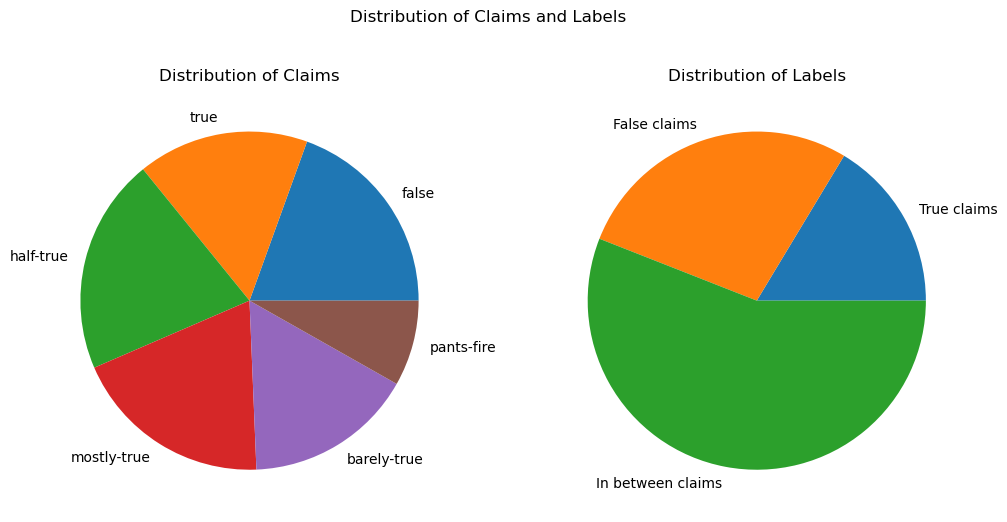

In [6]:
import matplotlib.pyplot as plt

claims = ['false','true', 'half-true','mostly-true','barely-true', 'pants-fire']

def count_claims(df, claim):
    count_claim = len(df[df['claim']== claim])
    return count_claim

claim_list= []
for x in claims:
    count_claim = count_claims(Liar_computed,x)
    claim_list.append(count_claim)
    print(f"Number of {x} statements: {count_claim}")


binary_labels = [0,1,2]
def count_label(df, labels):
    count_label = len(df[df['binary label']== labels])
    return count_label

claim_labels = []
for x in binary_labels:
    count_labels = count_label(Liar_computed,x)
    claim_labels.append(count_labels)
    print(f"Number of {x} statements: {count_labels}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Distribution of Claims and Labels')

ax1.pie(claim_list, labels=claims)
ax1.set_title('Distribution of Claims')

ax2.pie(claim_labels, labels=['True claims', 'False claims', 'In between claims'])
ax2.set_title('Distribution of Labels')

plt.show()


## Computing the different distributions

In [7]:
from pipe_line import values_by_label, compute_statistics


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sandrobarreshamers/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Complexity

In [8]:
label_com = values_by_label(Liar_computed, 'compressed_size')
stat, p = kruskal(*label_com) # unpack the elements 

print('Kruskal results:')
print(f'F-statistic: {stat:.3f}')
print(f'p-value: {p:.3e}')


Kruskal results:
F-statistic: 79.437
p-value: 5.629e-18


In [9]:
dunn_results = sp.posthoc_dunn(label_com, p_adjust='bonferroni')


print('Dunn results:')
print(dunn_results)


Dunn results:
          1             2             3
1  1.000000  4.915369e-05  2.893171e-02
2  0.000049  1.000000e+00  1.511753e-18
3  0.028932  1.511753e-18  1.000000e+00


### Readability

In [10]:
label_fke = values_by_label(Liar_computed, 'flesch_kincaid_reading_ease')
stat, p = kruskal(*label_fke) # unpack the elements 

print('Kruskal results:')
print(f'F-statistic: {stat:.3f}')
print(f'p-value: {p:.3e}')

Kruskal results:
F-statistic: 49.863
p-value: 1.487e-11


In [11]:
dunn_results = sp.posthoc_dunn(label_fke, p_adjust='bonferroni')


print('Dunn results:')
print(dunn_results)


Dunn results:
              1             2             3
1  1.000000e+00  1.028364e-10  1.222697e-02
2  1.028364e-10  1.000000e+00  1.800874e-07
3  1.222697e-02  1.800874e-07  1.000000e+00


### VADER Sentiment

In [41]:
vader_labels = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

labels = []
for vader in vader_labels:
    label_vader = values_by_label(Liar_computed, vader)
    stat, p = kruskal(*label_vader) # unpack the elements
    labels.append([stat, p])

for i, (stat, p), vader in zip(range(len(labels)), labels, vader_labels):
    print(f'{vader} : fstat {stat}; p {p}')


vader_neg : fstat 10.409693080422452; p 0.005489892854085175
vader_neu : fstat 10.17546297354846; p 0.00617200529376983
vader_pos : fstat 4.323321766239063; p 0.11513373846730762
vader_compound : fstat 1.999867736891534; p 0.36790377041511385


In [13]:
for i, (stat, p), vader in zip(range(len(labels)), labels, vader_labels):
    dunn_results = sp.posthoc_dunn(label_vader, p_adjust='bonferroni')
    print(f'Dunn results for {vader}:\n\n')
    print(dunn_results)
    

Dunn results for vader_neg:


     1         2         3
1  1.0  1.000000  1.000000
2  1.0  1.000000  0.516025
3  1.0  0.516025  1.000000
Dunn results for vader_neu:


     1         2         3
1  1.0  1.000000  1.000000
2  1.0  1.000000  0.516025
3  1.0  0.516025  1.000000
Dunn results for vader_pos:


     1         2         3
1  1.0  1.000000  1.000000
2  1.0  1.000000  0.516025
3  1.0  0.516025  1.000000
Dunn results for vader_compound:


     1         2         3
1  1.0  1.000000  1.000000
2  1.0  1.000000  0.516025
3  1.0  0.516025  1.000000


### NER

In [14]:
from pipe_line import count_named_entities

Liar_computed['num_entities'] = Liar_computed['object'].apply(count_named_entities)



In [15]:
label_NER = values_by_label(Liar_computed, 'flesch_kincaid_reading_ease')
stat, p = kruskal(*label_NER) # unpack the elements 

print('Kruskal results:')
print(f'F-statistic: {stat:.3f}')
print(f'p-value: {p:.3e}')

Kruskal results:
F-statistic: 49.863
p-value: 1.487e-11


In [16]:
dunn_results = sp.posthoc_dunn(label_NER, p_adjust='bonferroni')


print('Dunn results:')
print(dunn_results)


Dunn results:
              1             2             3
1  1.000000e+00  1.028364e-10  1.222697e-02
2  1.028364e-10  1.000000e+00  1.800874e-07
3  1.222697e-02  1.800874e-07  1.000000e+00


In [17]:
Liar_computed.head()

,Unnamed: 0,json_id,claim,object,flesch_kincaid_reading_ease,compressed_size,vader_neg,vader_neu,vader_pos,vader_compound,binary label,num_entities
0,0,10540.json,half-true,When did the decline of coal start? It started...,71.815000,11443.0,0.000,0.902,0.098,0.3612,2,2
1,1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",71.781579,9089.0,0.107,0.687,0.206,0.3182,2,4
2,2,1123.json,false,Health care reform legislation is likely to ma...,53.655000,5511.0,0.000,0.606,0.394,0.7579,1,0
3,3,9028.json,half-true,The economic turnaround started at the end of ...,61.325000,4708.0,0.000,1.000,0.000,0.0000,2,0
4,4,12465.json,true,The Chicago Bears have had more starting quart...,54.096667,12205.0,0.119,0.828,0.053,-0.4601,0,3


### POS

In [18]:
from pipe_line import count_pos

In [19]:
Liar_computed['pos counts'] = Liar_computed['object'].apply(count_pos)

In [20]:
Liar_computed.head()

,Unnamed: 0,json_id,claim,object,flesch_kincaid_reading_ease,compressed_size,vader_neg,vader_neu,vader_pos,vader_compound,binary label,num_entities,pos counts
0,0,10540.json,half-true,When did the decline of coal start? It started...,71.815000,11443.0,0.000,0.902,0.098,0.3612,2,2,"{'ADV': 2, 'AUX': 1, 'DET': 2, 'NOUN': 5, 'ADP..."
1,1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",71.781579,9089.0,0.107,0.687,0.206,0.3182,2,4,"{'PROPN': 7, 'VERB': 3, 'ADP': 4, 'PUNCT': 3, ..."
2,2,1123.json,false,Health care reform legislation is likely to ma...,53.655000,5511.0,0.000,0.606,0.394,0.7579,1,0,"{'NOUN': 7, 'AUX': 1, 'ADJ': 2, 'PART': 1, 'VE..."
3,3,9028.json,half-true,The economic turnaround started at the end of ...,61.325000,4708.0,0.000,1.000,0.000,0.0000,2,0,"{'DET': 3, 'ADJ': 1, 'NOUN': 3, 'VERB': 1, 'AD..."
4,4,12465.json,true,The Chicago Bears have had more starting quart...,54.096667,12205.0,0.119,0.828,0.053,-0.4601,0,3,"{'DET': 4, 'PROPN': 4, 'AUX': 1, 'VERB': 3, 'A..."


In [46]:
pos_tags = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
            'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
def create_input_vector(pos_count_dict):
    input_vector = np.zeros(len(pos_tags))
    for i, tag in enumerate(pos_tags):
        if tag in pos_count_dict:
            input_vector[i] = pos_count_dict[tag]
    return input_vector
Liar_computed['input vector'] = Liar_computed['pos counts'].apply(create_input_vector)



In [47]:
for tag in pos_tags:
    col_name = f'pos_{tag}'
    Liar_computed[col_name] = Liar_computed['input vector'].apply(lambda x: x[pos_tags.index(tag)] if tag in pos_tags else 0)
Liar_computed.columns
#Liar_computed.head()

Index(['Unnamed: 0', 'json_id', 'claim', 'object',
       'flesch_kincaid_reading_ease', 'compressed_size', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'binary label',
       'num_entities', 'pos counts', 'input vector', 'pos_ADJ', 'pos_ADP',
       'pos_ADV', 'pos_AUX', 'pos_CONJ', 'pos_CCONJ', 'pos_DET', 'pos_INTJ',
       'pos_NOUN', 'pos_NUM', 'pos_PART', 'pos_PRON', 'pos_PROPN', 'pos_PUNCT',
       'pos_SCONJ', 'pos_SYM', 'pos_VERB', 'pos_X'],
      dtype='object')

In [52]:
pos_labels = ['pos_NOUN', 'pos_ADJ', 'pos_VERB', 'pos_ADV', 'pos_ADP', 'pos_AUX', 'pos_CCONJ', 'pos_DET', 'pos_INTJ', 'pos_NUM', 'pos_PART', 'pos_PRON', 'pos_PROPN', 'pos_PUNCT', 'pos_SCONJ', 'pos_SYM', 'pos_X']

labels = []
for pos in pos_labels:
    label_pos = values_by_label(Liar_computed, pos)
    stat, p = kruskal(*label_pos) # unpack the elements
    labels.append([stat, p])

for i, (stat, p), pos in zip(range(len(labels)), labels, pos_labels):
       print(f'{pos} : fstat {stat}; p {p}')


pos_NOUN : fstat 74.42562883952174; p 6.897314694451533e-17
pos_ADJ : fstat 75.63363133229193; p 3.7702107990073795e-17
pos_VERB : fstat 45.05819719363287; p 1.6433754586485928e-10
pos_ADV : fstat 15.343928130378757; p 0.000465702255291164
pos_ADP : fstat 52.88463642780589; p 3.2828203050086716e-12
pos_AUX : fstat 10.672755272313356; p 0.004813274601537372
pos_CCONJ : fstat 30.78256967100686; p 2.0684733341776858e-07
pos_DET : fstat 17.70000951293461; p 0.0001433810542873743
pos_INTJ : fstat 1.6205299951697043; p 0.44474019552820465
pos_NUM : fstat 157.83110536457033; p 5.33839781071815e-35
pos_PART : fstat 15.798490526270482; p 0.0003710234598959158
pos_PRON : fstat 6.770194727289172; p 0.03387434405551494
pos_PROPN : fstat 49.15895156684152; p 2.1147999875958165e-11
pos_PUNCT : fstat 39.48929409787203; p 2.6607786034061635e-09
pos_SCONJ : fstat 50.565192976835576; p 1.0469064051354758e-11
pos_SYM : fstat 27.912685893597782; p 8.686348924034588e-07
pos_X : fstat 4.769992151936845; p 0

In [53]:
for i, (stat, p), pos in zip(range(len(labels)), labels, pos_labels):
    dunn_results = sp.posthoc_dunn(label_pos, p_adjust='bonferroni')
    print(f'Dunn results for {pos}:\n\n')
    print(dunn_results)
    

    


Dunn results for pos_NOUN:


          1         2         3
1  1.000000  0.091236  0.257834
2  0.091236  1.000000  1.000000
3  0.257834  1.000000  1.000000
Dunn results for pos_ADJ:


          1         2         3
1  1.000000  0.091236  0.257834
2  0.091236  1.000000  1.000000
3  0.257834  1.000000  1.000000
Dunn results for pos_VERB:


          1         2         3
1  1.000000  0.091236  0.257834
2  0.091236  1.000000  1.000000
3  0.257834  1.000000  1.000000
Dunn results for pos_ADV:


          1         2         3
1  1.000000  0.091236  0.257834
2  0.091236  1.000000  1.000000
3  0.257834  1.000000  1.000000
Dunn results for pos_ADP:


          1         2         3
1  1.000000  0.091236  0.257834
2  0.091236  1.000000  1.000000
3  0.257834  1.000000  1.000000
Dunn results for pos_AUX:


          1         2         3
1  1.000000  0.091236  0.257834
2  0.091236  1.000000  1.000000
3  0.257834  1.000000  1.000000
Dunn results for pos_CCONJ:


          1         2         3


## Basic classification

In [24]:
filtered_df = Liar_computed[Liar_computed['binary label'] != 2]

filtered_df.head()


,Unnamed: 0,json_id,claim,object,flesch_kincaid_reading_ease,compressed_size,vader_neg,vader_neu,vader_pos,vader_compound,...,pos_NOUN,pos_NUM,pos_PART,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SYM,pos_VERB,pos_X
2,2,1123.json,false,Health care reform legislation is likely to ma...,53.655000,5511.0,0.000,0.606,0.394,0.7579,...,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4,12465.json,true,The Chicago Bears have had more starting quart...,54.096667,12205.0,0.119,0.828,0.053,-0.4601,...,5.0,2.0,0.0,0.0,4.0,3.0,1.0,0.0,3.0,0.0
11,11,5947.json,false,When Mitt Romney was governor of Massachusetts...,58.429130,10582.0,0.085,0.810,0.105,0.1280,...,4.0,0.0,1.0,3.0,3.0,3.0,0.0,0.0,2.0,0.0
15,15,620.json,true,McCain opposed a requirement that the governme...,35.034643,11081.0,0.000,1.000,0.000,0.0000,...,4.0,0.0,0.0,1.0,2.0,6.0,1.0,0.0,5.0,0.0
19,19,10173.json,false,Women and men both are making less when you ad...,55.405000,8848.0,0.000,1.000,0.000,0.0000,...,4.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,3.0,0.0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight

In [26]:
features = ['flesch_kincaid_reading_ease', 'compressed_size', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound','num_entities']#,'pos label']
features3 = ['flesch_kincaid_reading_ease', 'compressed_size', 'vader_pos', 'num_entities', 'pos_NOUN', 'pos_ADJ', 'pos_VERB', 'pos_ADV']
features4 = ['flesch_kincaid_reading_ease', 'compressed_size', 'vader_pos', 'num_entities','pos_NOUN', 'pos_ADJ',
       'pos_VERB', 'pos_ADV', 'pos_ADP', 'pos_AUX', 'pos_CONJ', 'pos_CCONJ',
       'pos_DET', 'pos_INTJ', 'pos_NUM', 'pos_PART', 'pos_PRON', 'pos_PROPN',
       'pos_PUNCT', 'pos_SCONJ', 'pos_SYM', 'pos_X']


In [27]:
X = filtered_df[features4]

y = filtered_df['binary label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Scale the features and normalize the data
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_res_scaled = scaler.transform(X_test)

### Random forrest

Accuracy: 0.6319290465631929
[[ 93 236]
 [ 96 477]]


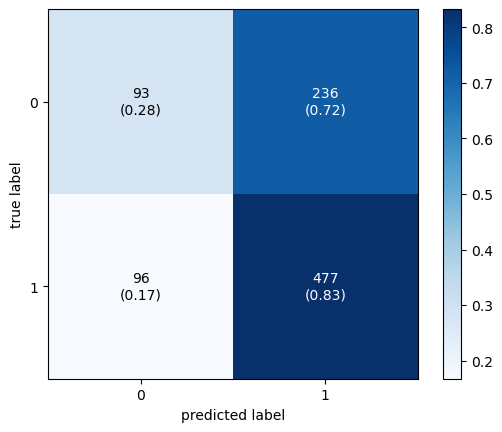

In [28]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res_scaled, y_train_res)
y_pred = clf.predict(X_test_res_scaled)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


cm_2 =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_2,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

# improved from 51% to 55%
print(cm_2)

In [32]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test_res_scaled)
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 score:', f1)


F1 score: 0.6022246948924489


In [33]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(clf, X_train_res_scaled, y_train_res, cv=kfold, scoring='f1_macro')

print("f1 score k fold crss: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold crss: 0.71 (+/- 0.02)


### Gradient  booster

              precision    recall  f1-score   support

           0       0.54      0.27      0.36       329
           1       0.67      0.87      0.76       573

    accuracy                           0.65       902
   macro avg       0.61      0.57      0.56       902
weighted avg       0.63      0.65      0.61       902

Accuracy: 0.6496674057649667


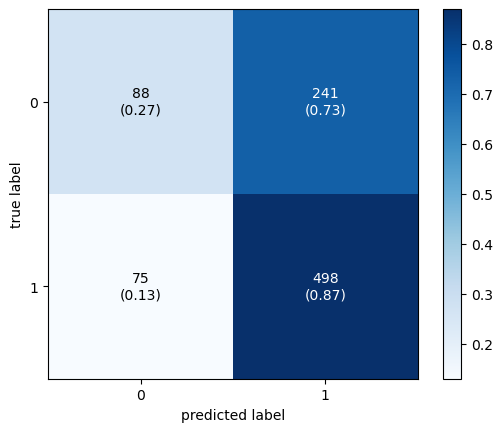

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Instantiate the model with hyperparameters
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model to the training data
gb_clf.fit(X_train_res_scaled, y_train_res)

# Predict on the test data
y_pred = gb_clf.predict(X_test_res_scaled)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))

cm_3 =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_3,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

In [35]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(gb_clf, X_train_res_scaled, y_train_res, cv=kfold, scoring='accuracy')

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


Accuracy: 0.70 (+/- 0.01)


In [36]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test_res_scaled)
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 score:', f1)

F1 score: 0.6022246948924489


In [38]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(clf, X_train_res_scaled, y_train_res, cv=kfold, scoring='f1_macro')

print("f1 score k fold crss:%0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold crss:0.71 (+/- 0.02)
